<a href="https://colab.research.google.com/github/Milad-Khanchi/Text_Classification/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Naive Bayes model:

#Bernoulli Naive Bayes

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import tensorflow_datasets as tfds
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import numpy as np
import re
from scipy import sparse
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"],
                                  batch_size=-1, as_supervised=True)

x_train, y_train = tfds.as_numpy(train_data)
x_test, y_test = tfds.as_numpy(test_data)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4743OF/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4743OF/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4743OF/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print('Input  Trainset shape: ' ,x_train.shape)
print('Output Trainset shape: ' ,y_train.shape)
print('Input  Testset  shape: ' ,x_test.shape)
print('Output Testset  shape: ' ,y_test.shape)

Input  Trainset shape:  (25000,)
Output Trainset shape:  (25000,)
Input  Testset  shape:  (25000,)
Output Testset  shape:  (25000,)


In [ ]:
def logsumexp(Z):                                                # dimension C x N
    Zmax = np.max(Z,axis=0)[None,:]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

class BernoulliNaiveBayes:
    def __init__(self):
      return

    def fit(self, x, y, alpha_pi, beta_pi, alpha, beta):
      N, D = x.shape
      C = np.max(y) + 1
      prob= np.zeros((C,D))
      Nc = np.zeros(C) # number of instances in class c
      for c in range(C):
          x_c = x[y == c]                           #slice all the elements from class c
          Nc[c] = x_c.shape[0]                      #get number of elements of class c
          if c==1:
            add= alpha
          else:
            add=beta
          prob[c,:] = (np.sum(x_c, 0)+ add)/(Nc[c]+ alpha+ beta) #np.sum(x_c, 0)
      #### NEED TO INCLUDE BAYESIAN INFERENCE!
      #self.denom= denom
      self.prior = (Nc+alpha_pi)/(N+alpha_pi+beta_pi)                               # C x D
      self.prob = prob
      return self

    def predict(self, x):
      N, D = x.shape
      log_prior= np.log(self.prior)
      log_likelihood= np.zeros((N, self.prob.shape[0]))
      for c in range(self.prob.shape[0]):
        for n in range(N):
          prob=np.expand_dims(self.prob[c, :], axis=0)
          #### NEED TO INCLUDE BAYESIAN INFERENCE!
          x_test=x[n, :].toarray()
          prob= np.where(x_test==0, 1-prob, prob);
          log_likelihood[n, c]= np.sum(np.log(prob), axis=1)

      log_posterior =np.expand_dims(log_prior, axis=0)+log_likelihood
      posterior = np.exp(log_posterior - logsumexp(log_posterior))
      return posterior

    def evaluate_acc(self,yh, y):
      return np.sum(yh == y)/yh.shape[0]


In [ ]:
stopword_list=nltk.corpus.stopwords.words('english')
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

## Fitting Bernoulli model with different kinds of preprocessing

### No clean up

In [ ]:
vectorizer = CountVectorizer(binary=True)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 74849


#### Without priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

<ipython-input-87-240c21986645>:55: RuntimeWarning: divide by zero encountered in log
  log_likelihood[n, c]= np.sum(np.log(prob), axis=1)


Accuracy: 0.65612


#### With priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.808


### No clean up but with limits

In [ ]:
vectorizer = CountVectorizer(min_df=0.005, max_df=0.6, binary=True)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 3195


#### Without priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.8366


#### With priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.83568


### No clean up with different limits

In [ ]:
vectorizer = CountVectorizer(min_df=0.05, max_df=0.6, binary=True)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 413


#### Without priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.69308


#### With priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.69284


### Stop words and limits

In [ ]:
vectorizer = CountVectorizer(stop_words=stopword_list, min_df=0.005, max_df=0.6, binary=True)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 3075


#### Without priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.84756


#### With priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.84796


### Analysis with different limits

In [ ]:
lower_limits=[0, 0.005, 0.01, 0.015]
upper_limits=[0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
for l in lower_limits:
  for u in upper_limits:
    vectorizer = CountVectorizer(stop_words=stopword_list, min_df=l, max_df=u, binary=True)
    X_train = vectorizer.fit_transform(x_train)
    dic= vectorizer.get_feature_names_out()
    X_test=vectorizer.transform(x_test)
    model=BernoulliNaiveBayes()
    params=model.fit(X_train, y_train, 1, 1, 10, 10)
    y_prob=model.predict(X_test)
    y_pred = np.argmax(y_prob, 1)
    print("Accuracy for lower limit "+str(l)+ " and higher limit "+ str(u)+":",model.evaluate_acc(y_pred, y_test), "; Length of dictionary:", len(dic))


Accuracy for lower limit 0 and higher limit 0.35: 0.80912 ; Length of dictionary: 74698
Accuracy for lower limit 0 and higher limit 0.4: 0.80908 ; Length of dictionary: 74699
Accuracy for lower limit 0 and higher limit 0.45: 0.80908 ; Length of dictionary: 74699
Accuracy for lower limit 0 and higher limit 0.5: 0.80988 ; Length of dictionary: 74700
Accuracy for lower limit 0 and higher limit 0.55: 0.80988 ; Length of dictionary: 74700
Accuracy for lower limit 0 and higher limit 0.6: 0.80996 ; Length of dictionary: 74703
Accuracy for lower limit 0 and higher limit 0.65: 0.81216 ; Length of dictionary: 74704
Accuracy for lower limit 0.005 and higher limit 0.35: 0.84764 ; Length of dictionary: 3070
Accuracy for lower limit 0.005 and higher limit 0.4: 0.84724 ; Length of dictionary: 3071
Accuracy for lower limit 0.005 and higher limit 0.45: 0.84724 ; Length of dictionary: 3071
Accuracy for lower limit 0.005 and higher limit 0.5: 0.84732 ; Length of dictionary: 3072
Accuracy for lower limit 

### Lemmatizer, stop words and limits

In [ ]:
vectorizer = CountVectorizer(stop_words=stopword_list, tokenizer=LemmaTokenizer(), min_df=0.005, max_df=0.6, binary=True)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 2910


#### Without priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.83764


#### With priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.8358


### After cleaning html tags

In [ ]:
for i in range(len(x_train)):
  x_train[i]=strip_html(x_train[i]) ## Only removing html tags for now
  x_test[i]=strip_html(x_test[i])

<ipython-input-7-25238354f317>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
vectorizer = CountVectorizer(stop_words=stopword_list, tokenizer=LemmaTokenizer(), min_df=0.005, max_df=0.6, binary=True)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 2880


#### Without priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.83692


#### With priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.83672


### Also cleaning special characters

In [ ]:
for i in range(len(x_train)):
  x_train[i] = re.sub(r'[^a-zA-z0-9\s]', ' ', x_train[i]).lower()
  x_test[i] = re.sub(r'[^a-zA-z0-9\s]', ' ', x_test[i]).lower()

In [ ]:
vectorizer = CountVectorizer(stop_words=stopword_list, tokenizer=LemmaTokenizer(), min_df=0.005, max_df=0.4, binary=True)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 2958


#### Without priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.84736


#### With priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.84772


### Analysis with different limits

In [ ]:
lower_limits=[0, 0.005, 0.01, 0.015]
upper_limits=[0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
for l in lower_limits:
  for u in upper_limits:
    vectorizer = CountVectorizer(stop_words=stopword_list, tokenizer=LemmaTokenizer(), min_df=l, max_df=u, binary=True)
    X_train = vectorizer.fit_transform(x_train)
    dic= vectorizer.get_feature_names_out()
    X_test=vectorizer.transform(x_test)
    model=BernoulliNaiveBayes()
    params=model.fit(X_train, y_train, 1, 1, 10, 10)
    y_prob=model.predict(X_test)
    y_pred = np.argmax(y_prob, 1)
    print("Accuracy for lower limit "+str(l)+ " and higher limit "+ str(u)+":",model.evaluate_acc(y_pred, y_test), "; Length of dictionary: ", len(dic))

Accuracy for lower limit 0 and higher limit 0.35: 0.81588 ; Length of dictionary:  67893
Accuracy for lower limit 0 and higher limit 0.4: 0.81564 ; Length of dictionary:  67894
Accuracy for lower limit 0 and higher limit 0.45: 0.81536 ; Length of dictionary:  67896
Accuracy for lower limit 0 and higher limit 0.5: 0.81624 ; Length of dictionary:  67897
Accuracy for lower limit 0 and higher limit 0.55: 0.81624 ; Length of dictionary:  67897
Accuracy for lower limit 0 and higher limit 0.6: 0.81588 ; Length of dictionary:  67899
Accuracy for lower limit 0 and higher limit 0.65: 0.81804 ; Length of dictionary:  67901
Accuracy for lower limit 0.005 and higher limit 0.35: 0.84708 ; Length of dictionary:  2957
Accuracy for lower limit 0.005 and higher limit 0.4: 0.84772 ; Length of dictionary:  2958
Accuracy for lower limit 0.005 and higher limit 0.45: 0.84768 ; Length of dictionary:  2960
Accuracy for lower limit 0.005 and higher limit 0.5: 0.84688 ; Length of dictionary:  2961
Accuracy for l

### With other limits

In [ ]:
vectorizer = CountVectorizer(stop_words=stopword_list, tokenizer=LemmaTokenizer(), min_df=0.001, max_df=0.65, binary=True)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 9429


#### Without priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

<ipython-input-4-240c21986645>:55: RuntimeWarning: divide by zero encountered in log
  log_likelihood[n, c]= np.sum(np.log(prob), axis=1)


Accuracy: 0.8252


#### With priors

In [ ]:
model=BernoulliNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.8296


# Multinomial Naive Bayes

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import tensorflow_datasets as tfds
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import numpy as np
import re
from scipy import sparse
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"],
                                  batch_size=-1, as_supervised=True)

x_train, y_train = tfds.as_numpy(train_data)
x_test, y_test = tfds.as_numpy(test_data)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGQ9H9L/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGQ9H9L/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGQ9H9L/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print('Input  Trainset shape: ' ,x_train.shape)
print('Output Trainset shape: ' ,y_train.shape)
print('Input  Testset  shape: ' ,x_test.shape)
print('Output Testset  shape: ' ,y_test.shape)

Input  Trainset shape:  (25000,)
Output Trainset shape:  (25000,)
Input  Testset  shape:  (25000,)
Output Testset  shape:  (25000,)


In [ ]:
def logsumexp(Z):                                                # dimension C x N
    Zmax = np.max(Z,axis=0)[None,:]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

class MultinomialNaiveBayes:
    def __init__(self):
      return

    def fit(self, x, y, alpha_pi, beta_pi, alpha, beta):
      N, D = x.shape
      C = np.max(y) + 1
      prob= np.zeros((C,D))
      Nc = np.zeros(C) # number of instances in class c
      for c in range(C):
          x_c = x[y == c]                           #slice all the elements from class c
          Nc[c] = x_c.shape[0]                      #get number of elements of class c
          #prob[c,:] = (np.sum(x_c, 0)+ alpha)/(np.sum(x_c) +alpha+ beta)
          if c==1:
            add= alpha
          else:
            add=beta
          prob[c,:] = ((np.sum(x_c, 0)+ add)*100)/(np.sum(x_c)+ alpha+ beta) #np.sum(x_c, 0)
          #denom[c]= np.sum(x_c)
      #### NEED TO INCLUDE BAYESIAN INFERENCE!
      #self.denom= denom
      self.prior = (Nc+alpha_pi)/(N+alpha_pi+beta_pi)                               # C x D
      self.prob = prob
      #self.alpha= alpha
      #self.beta= beta
      return self

    def predict(self, x):
      N, D = x.shape
      log_prior= np.log(self.prior)
      log_likelihood= np.zeros((N, self.prob.shape[0]))
      """
      for c in range(self.prob.shape[0]):
        prob=np.expand_dims(self.prob[c, :], axis=0)
        #print(self.prob.shape, prob.shape)
        log_likelihood=np.sum(np.log(sparse.csr_matrix.multiply(np.repeat(prob, N, axis=0), x), axis=1)) ##Adding index the other way doesn't work for sparse arrays
      """
      for c in range(self.prob.shape[0]):
        for n in range(N):
          prob=np.expand_dims(self.prob[c, :], axis=0)
          x_test=x[n, :].toarray()
          log_likelihood[n, c]= np.sum(np.log(np.power(prob,x_test)), axis=1)

      log_posterior =np.expand_dims(log_prior, axis=0)+log_likelihood
      posterior = np.exp(log_posterior - logsumexp(log_posterior))
      return posterior

    def evaluate_acc(self,yh, y):
      return np.sum(yh == y)/yh.shape[0]


In [ ]:
print(x_train[2])
print(x_train[4])
print(x_train[6])

b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.'
b'As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female libido. When men are around they want to be pursued, but

In [ ]:
stopword_list=nltk.corpus.stopwords.words('english')
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

## Fitting models with different kinds of preprocessing

### No clean up

In [ ]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 74849


#### Without priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

<ipython-input-5-f4b4030e8c91>:47: RuntimeWarning: divide by zero encountered in log
  log_likelihood[n, c]= np.sum(np.log(np.power(prob,x_test)), axis=1)


Accuracy: 0.63992


#### With priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.75916


### No clean up but with limits

In [ ]:
vectorizer = CountVectorizer(min_df=0.01, max_df=0.4)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 1764


#### Without priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.83308


#### With priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.83272


### No clean up with different limits

In [ ]:
vectorizer = CountVectorizer(min_df=0.05, max_df=0.6)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 413


#### Without priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.79024


#### With priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.78984


### Stop words and limits

In [ ]:
vectorizer = CountVectorizer(stop_words=stopword_list, min_df=0.01, max_df=0.4)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 1668


In [ ]:
for d in vectorizer.get_feature_names_out():
  print(d)

10
100
11
12
15
20
30
40
50
60
70
80
90
ability
able
absolute
absolutely
absurd
academy
accent
accept
accident
according
accurate
across
act
acted
acting
action
actions
actor
actors
actress
actresses
acts
actual
actually
adaptation
add
added
addition
adds
admit
adult
adults
adventure
affair
afraid
age
agent
ago
agree
ahead
air
al
alive
allow
allowed
almost
alone
along
already
also
although
always
amazing
america
american
americans
among
amount
amusing
angry
animal
animals
animated
animation
annoying
another
answer
anti
anybody
anymore
anyone
anything
anyway
anywhere
apart
apartment
apparent
apparently
appeal
appear
appearance
appeared
appears
appreciate
approach
area
army
around
art
artist
artistic
aside
ask
asked
asks
aspect
aspects
atmosphere
attack
attempt
attempts
attention
attractive
audience
audiences
available
average
avoid
award
aware
away
awesome
awful
baby
back
background
bad
badly
band
bar
barely
based
basic
basically
battle
beat
beautiful
beautifully
beauty
became
become
be

#### Without priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.84604


#### With priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10, 10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.846


### Analysis with different limits

In [ ]:
lower_limits=[0, 0.005, 0.01, 0.015]
upper_limits=[0.35 , 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
for l in lower_limits:
  for u in upper_limits:
    vectorizer = CountVectorizer(stop_words=stopword_list, min_df=l, max_df=u)
    X_train = vectorizer.fit_transform(x_train)
    dic= vectorizer.get_feature_names_out()
    X_test=vectorizer.transform(x_test)
    model=MultinomialNaiveBayes()
    params=model.fit(X_train, y_train, 1,1,10, 10)
    y_prob=model.predict(X_test)
    y_pred = np.argmax(y_prob, 1)
    print("Accuracy for lower limit "+str(l)+ " and higher limit "+ str(u)+":",model.evaluate_acc(y_pred, y_test), "; Length of dictionary: ", len(dic))

Accuracy for lower limit 0 and higher limit 0.35: 0.79912 ; Length of dictionary:  74698
Accuracy for lower limit 0 and higher limit 0.4: 0.79932 ; Length of dictionary:  74699
Accuracy for lower limit 0 and higher limit 0.45: 0.79932 ; Length of dictionary:  74699
Accuracy for lower limit 0 and higher limit 0.5: 0.79864 ; Length of dictionary:  74700
Accuracy for lower limit 0 and higher limit 0.55: 0.79864 ; Length of dictionary:  74700
Accuracy for lower limit 0 and higher limit 0.6: 0.79876 ; Length of dictionary:  74703
Accuracy for lower limit 0 and higher limit 0.65: 0.79616 ; Length of dictionary:  74704
Accuracy for lower limit 0.005 and higher limit 0.35: 0.84032 ; Length of dictionary:  3070
Accuracy for lower limit 0.005 and higher limit 0.4: 0.84028 ; Length of dictionary:  3071
Accuracy for lower limit 0.005 and higher limit 0.45: 0.84028 ; Length of dictionary:  3071
Accuracy for lower limit 0.005 and higher limit 0.5: 0.83912 ; Length of dictionary:  3072
Accuracy for l

### Lemmatizer, stop words and limits

In [ ]:
vectorizer = CountVectorizer(stop_words=stopword_list, tokenizer=LemmaTokenizer(), min_df=0.01, max_df=0.4)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 1621


In [ ]:
for d in vectorizer.get_feature_names_out():
  print(d)

!
$
%
&
'
'd
'll
'm
're
'the
've
*
-
--
..
...
....
1
10
10/10
100
15
2
20
3
30
4
40
5
50
6
60
7
70
8
80
9
90
:
;
?
ability
able
absolute
absolutely
absurd
academy
accent
accept
accident
according
accurate
across
act
acted
acting
action
actor
actress
actual
actually
adam
adaptation
add
added
addition
admit
adult
adventure
affair
afraid
age
agent
ago
agree
ahead
air
alien
alive
allow
allowed
almost
alone
along
already
also
although
always
amazing
america
american
among
amount
amusing
angel
angle
angry
animal
animated
animation
annoying
another
answer
anybody
anymore
anyone
anything
anyway
anywhere
apart
apartment
apparent
apparently
appeal
appear
appearance
appeared
appears
appreciate
approach
area
arm
army
around
art
artist
artistic
aside
ask
asked
asks
aspect
atmosphere
attack
attempt
attention
attitude
attractive
audience
author
available
average
avoid
award
aware
away
awesome
awful
b
baby
back
background
bad
badly
ball
band
bar
barely
based
basic
basically
battle
bear
beat
beautiful

#### Without priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.83784


#### With priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.83764


### After cleaning html tags

In [ ]:
for i in range(len(x_train)):
  x_train[i]=strip_html(x_train[i]) ## Only removing html tags for now
  x_test[i]=strip_html(x_test[i])

<ipython-input-5-25238354f317>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
vectorizer = CountVectorizer(stop_words=stopword_list, tokenizer=LemmaTokenizer(), min_df=0.01, max_df=0.4)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 1610


In [ ]:
for d in vectorizer.get_feature_names_out():
  print(d)

!
$
%
&
'
'd
'll
'm
're
'the
've
*
-
--
..
...
....
.....
.the
1
10
100
15
2
20
3
30
4
40
5
50
6
60
7
70
8
80
9
90
:
;
?
ability
able
absolute
absolutely
absurd
academy
accent
accept
accident
according
accurate
across
act
acted
acting
action
actor
actress
actual
actually
adam
adaptation
add
added
addition
admit
adult
adventure
affair
afraid
age
agent
ago
agree
ahead
air
alien
alive
allow
allowed
almost
alone
along
already
also
although
always
amazing
america
american
among
amount
amusing
angel
angle
angry
animal
animated
animation
annoying
another
answer
anybody
anymore
anyone
anything
anyway
anywhere
apart
apartment
apparent
apparently
appeal
appear
appearance
appeared
appears
appreciate
approach
area
arm
army
around
art
artist
artistic
aside
ask
asked
asks
aspect
atmosphere
attack
attempt
attention
attitude
attractive
audience
author
available
average
avoid
award
aware
away
awesome
awful
b
baby
back
background
bad
badly
ball
band
bar
barely
based
basic
basically
battle
bear
beat
beau

#### Without priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.83548


#### With priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.835


### Also cleaning special characters

In [ ]:
for i in range(len(x_train)):
  x_train[i] = re.sub(r'[^a-zA-z0-9\s]', ' ', x_train[i]).lower()
  x_test[i] = re.sub(r'[^a-zA-z0-9\s]', ' ', x_test[i]).lower()

In [ ]:
vectorizer = CountVectorizer(stop_words=stopword_list, tokenizer=LemmaTokenizer(), min_df=0.01, max_df=0.35)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 1666


In [ ]:
for d in vectorizer.get_feature_names_out():
  print(d)

1
10
100
11
12
15
2
20
3
30
4
40
5
50
6
60
7
70
8
80
9
90
ability
able
absolute
absolutely
absurd
academy
accent
accept
accident
according
accurate
across
act
acted
acting
action
actor
actress
actual
actually
adam
adaptation
add
added
addition
admit
adult
adventure
affair
afraid
age
agent
ago
agree
ahead
air
al
alien
alive
allow
allowed
almost
alone
along
already
also
although
always
amazing
america
american
among
amount
amusing
angel
angle
angry
animal
animated
animation
annoying
another
answer
anti
anybody
anymore
anyone
anything
anyway
anywhere
apart
apartment
apparent
apparently
appeal
appear
appearance
appeared
appears
appreciate
approach
area
arm
army
around
art
artist
artistic
aside
ask
asked
asks
aspect
atmosphere
attack
attempt
attention
attitude
attractive
audience
author
available
average
avoid
award
aware
away
awesome
awful
b
baby
back
background
bad
badly
ball
band
bar
barely
based
basic
basically
battle
bear
beat
beautiful
beautifully
beauty
became
become
becomes
becoming

#### Without priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.844


#### With priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.844


### Analysis with different limits

In [ ]:
lower_limits=[0, 0.005, 0.01, 0.015]
upper_limits=[0.35 , 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
for l in lower_limits:
  for u in upper_limits:
    vectorizer = CountVectorizer(stop_words=stopword_list, tokenizer=LemmaTokenizer(), min_df=l, max_df=u)
    X_train = vectorizer.fit_transform(x_train)
    dic= vectorizer.get_feature_names_out()
    X_test=vectorizer.transform(x_test)
    model=MultinomialNaiveBayes()
    params=model.fit(X_train, y_train, 1,1,10, 10)
    y_prob=model.predict(X_test)
    y_pred = np.argmax(y_prob, 1)
    print("Accuracy for lower limit "+str(l)+ " and higher limit "+ str(u)+":",model.evaluate_acc(y_pred, y_test),"; Length of dictionary: ", len(dic))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn(


Accuracy for lower limit 0 and higher limit 0.35: 0.80136 ; Length of dictionary:  67893
Accuracy for lower limit 0 and higher limit 0.4: 0.8014 ; Length of dictionary:  67894
Accuracy for lower limit 0 and higher limit 0.45: 0.80136 ; Length of dictionary:  67896
Accuracy for lower limit 0 and higher limit 0.5: 0.80032 ; Length of dictionary:  67897
Accuracy for lower limit 0 and higher limit 0.55: 0.80032 ; Length of dictionary:  67897
Accuracy for lower limit 0 and higher limit 0.6: 0.80044 ; Length of dictionary:  67899
Accuracy for lower limit 0 and higher limit 0.65: 0.79732 ; Length of dictionary:  67901
Accuracy for lower limit 0.005 and higher limit 0.35: 0.839 ; Length of dictionary:  2957
Accuracy for lower limit 0.005 and higher limit 0.4: 0.83872 ; Length of dictionary:  2958
Accuracy for lower limit 0.005 and higher limit 0.45: 0.83912 ; Length of dictionary:  2960
Accuracy for lower limit 0.005 and higher limit 0.5: 0.83856 ; Length of dictionary:  2961
Accuracy for lowe

### Checking for limits beyond the optimal obtained above (lower=0.01; upper=0.35)

In [ ]:
vectorizer = CountVectorizer(stop_words=stopword_list, tokenizer=LemmaTokenizer(), min_df=0.01, max_df=0.3)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 1657


In [ ]:
for d in vectorizer.get_feature_names_out():
  print(d)

1
10
100
11
12
15
2
20
3
30
4
40
5
50
6
60
7
70
8
80
9
90
ability
able
absolute
absolutely
absurd
academy
accent
accept
accident
according
accurate
across
act
acted
acting
action
actor
actress
actual
actually
adam
adaptation
add
added
addition
admit
adult
adventure
affair
afraid
age
agent
ago
agree
ahead
air
al
alien
alive
allow
allowed
almost
alone
along
already
also
although
always
amazing
america
american
among
amount
amusing
angel
angle
angry
animal
animated
animation
annoying
another
answer
anti
anybody
anymore
anyone
anything
anyway
anywhere
apart
apartment
apparent
apparently
appeal
appear
appearance
appeared
appears
appreciate
approach
area
arm
army
around
art
artist
artistic
aside
ask
asked
asks
aspect
atmosphere
attack
attempt
attention
attitude
attractive
audience
author
available
average
avoid
award
aware
away
awesome
awful
b
baby
back
background
bad
badly
ball
band
bar
barely
based
basic
basically
battle
bear
beat
beautiful
beautifully
beauty
became
become
becomes
becoming

#### Without priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.84328


#### With priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.84348


### With other limits

In [ ]:
vectorizer = CountVectorizer(stop_words=stopword_list, tokenizer=LemmaTokenizer(), min_df=0.001, max_df=0.65)
X_train = vectorizer.fit_transform(x_train)
dic= vectorizer.get_feature_names_out()
X_test=vectorizer.transform(x_test)

In [ ]:
print("Dictionary length:", len(vectorizer.get_feature_names_out()))

Dictionary length: 9429


In [ ]:
for d in vectorizer.get_feature_names_out():
  print(d)

Streaming output truncated to the last 5000 lines.
inferior
infested
infidelity
infinitely
inflicted
influence
influenced
influential
info
inform
information
informative
informed
informs
ing
ingenious
ingenuity
ingredient
ingrid
inhabit
inhabitant
inhabited
inherent
inherently
inheritance
inherited
initial
initially
inject
injured
injury
injustice
inmate
inner
innocence
innocent
innovation
innovative
innuendo
insane
insanely
insanity
insect
insecure
insecurity
insert
inserted
inside
insight
insightful
insignificant
insipid
insist
insisted
insists
insomnia
insomniac
inspector
inspiration
inspirational
inspire
inspired
inspires
inspiring
installment
instance
instant
instantly
instead
instinct
institution
instruction
instructor
instrument
instrumental
insult
insulted
insulting
insurance
intact
integral
integrated
integrity
intellect
intellectual
intellectually
intelligence
intelligent
intelligently
intend
intended
intends
intense
intensely
intensity
intent
intention
intentional
intentiona

#### Without priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 0,0,0,0)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

<ipython-input-44-3e54b638b994>:47: RuntimeWarning: divide by zero encountered in log
  log_likelihood[n, c]= np.sum(np.log(np.power(prob,x_test)), axis=1)


Accuracy: 0.80976


#### With priors

In [ ]:
model=MultinomialNaiveBayes()
params=model.fit(X_train, y_train, 1,1,10,10)
y_prob=model.predict(X_test)
y_pred = np.argmax(y_prob, 1)
print("Accuracy:",model.evaluate_acc(y_pred, y_test))

Accuracy: 0.81364


#BERT model:

Dataset load:

In [ ]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"],
                                  batch_size=-1, as_supervised=True)

x_train, y_train = tfds.as_numpy(train_data)
x_test, y_test = tfds.as_numpy(test_data)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePUP4FX/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePUP4FX/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePUP4FX/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print('Input  Trainset shape: ' ,x_train.shape)
print('Output Trainset shape: ' ,y_train.shape)
print('Input  Testset  shape: ' ,x_test.shape)
print('Output Testset  shape: ' ,y_test.shape)

Input  Trainset shape:  (25000,)
Output Trainset shape:  (25000,)
Input  Testset  shape:  (25000,)
Output Testset  shape:  (25000,)


In [ ]:
x_train[0]

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [ ]:
y_train[0]

0

Use Kaggle code:

In [ ]:
import sys
import numpy as np
import random as rn
import pandas as pd
!pip install torch
import torch
!pip install pytorch_pretrained_bert
# from pytorch_pretrained_bert import BertModel
from torch import nn
# from torchnlp.datasets import imdb_dataset      # --> We are using our own uploaded dataset.
from pytorch_pretrained_bert import BertTokenizer
from keras import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 90.9 MB/s eta 0:00:00


In [ ]:
#Initializing seed values to stabilize the outcomes.
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

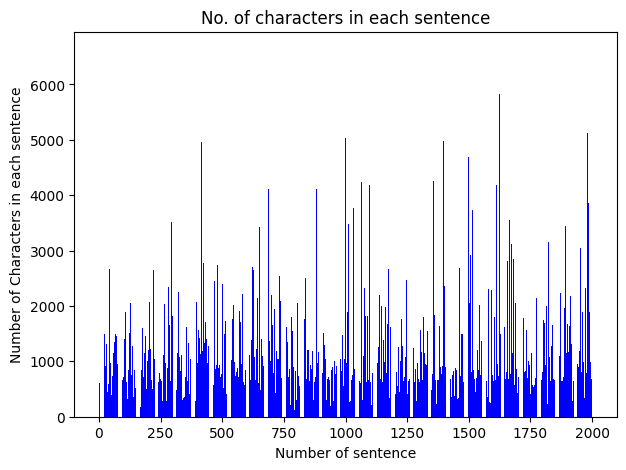

In [ ]:
sentences = [len(sent) for sent in x_train[0:2000]]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,2001), sentences, color = ['blue'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

In [ ]:
np.mean(sentences)

1297.963

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 3986169.44B/s]


Prepare data for tokenize:

In [ ]:
for i in range(len(x_train)):
  x_train[i] = str(x_train[i])[2:-1]

for i in range(len(x_test)):
  x_test[i] = str(x_test[i])[2:-1]

In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t) + ['[SEP]'], x_train))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t) + ['[SEP]'], x_test))

In [ ]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

Streaming output truncated to the last 5000 lines.


In [ ]:
train_tokens_ids[100].shape

(512,)

In [ ]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks =  [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

Define BERT

In [ ]:
!pip install bertviz
from bertviz import head_view, model_view

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.1 MB/s eta 0:00:00


In [ ]:
!pip install transformers
from transformers import BertConfig, BertModel

configuration = BertConfig(is_decoder = True)
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
# Accessing the model configuration
configuration = model.config

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        #self.bert = BertModel.from_pretrained('bert-base-uncased', config = config)
        self.bert = model

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, tokens, masks=None):
        pooled_output = self.bert(tokens, attention_mask=masks) #, output_all_encoded_layers=True
        dropout_output = self.dropout(pooled_output[1])
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba, pooled_output[2]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()     # running BERT on CUDA_GPU

Tune BERT:

In [ ]:
BATCH_SIZE = 4
EPOCHS = 10

In [ ]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(y_train.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(y_test.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.07328M'

In [ ]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
param_optimizer = list(bert_clf.sigmoid.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [ ]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits, attention = bert_clf(token_ids, masks)

        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()


        bert_clf.zero_grad()
        batch_loss.backward()


        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))

        # attention = torch.stack(attention, dim=0).squeeze()
        # attention = attention.mean(dim=1)



In [ ]:
bert_clf.eval()
bert_predicted = []
attention_eval = []
all_logits = []
j = 0
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits[0], labels)
        numpy_logits = logits[0].cpu().detach().numpy()

        bert_predicted += list(numpy_logits[:, 0] > 0.5)

        if j < 20:
          for i in range(4):
            attention_eval.append(logits[-1][-1][i][-3].cpu().detach().numpy())
          j = j + 1

        all_logits += list(numpy_logits[:, 0])

Without Fine-tuning pre-trained weights:

In [ ]:
print(classification_report(y_test, bert_predicted))

              precision    recall  f1-score   support

           0       0.50      0.93      0.65     12500
           1       0.54      0.08      0.15     12500

    accuracy                           0.51     25000
   macro avg       0.52      0.51      0.40     25000
weighted avg       0.52      0.51      0.40     25000



With fine-tuning (With batch size of 4 and 10 epoch):

In [ ]:
print(classification_report(y_test, bert_predicted))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     12500
           1       0.91      0.95      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



Wrong predicted attention:

In [ ]:
for i in range(len(y_test)):
  i = i + 41
  if y_test[i] != bert_predicted[i]:
    print("Not equal", i)
    print("real label is:", y_test[i])
    print("predicted label is:", bert_predicted[i])
    break

Not equal 43
real label is: 1
predicted label is: False


In [ ]:
# attention_eval[1]
x_test[43]

"I find it sad that just because Edward Norton did not want to be in the film or have anything to do with it, people automatically think the movie sucks without even watching it or giving it a chance. I really hope Norton did not do this. He is a fine actor and all but he scared people away from a decent movie.<br /><br />I found it entertaining. It wasn't mind blowing or anything with crazy special effects, but it was not a bad. It was fun to watch. But yea, definitely not a bad/horrible movie.<br /><br />7/10"

In [ ]:
tokenizer.convert_ids_to_tokens(test_tokens_ids[43])[:180]

['[CLS]',
 'i',
 'find',
 'it',
 'sad',
 'that',
 'just',
 'because',
 'edward',
 'norton',
 'did',
 'not',
 'want',
 'to',
 'be',
 'in',
 'the',
 'film',
 'or',
 'have',
 'anything',
 'to',
 'do',
 'with',
 'it',
 ',',
 'people',
 'automatically',
 'think',
 'the',
 'movie',
 'sucks',
 'without',
 'even',
 'watching',
 'it',
 'or',
 'giving',
 'it',
 'a',
 'chance',
 '.',
 'i',
 'really',
 'hope',
 'norton',
 'did',
 'not',
 'do',
 'this',
 '.',
 'he',
 'is',
 'a',
 'fine',
 'actor',
 'and',
 'all',
 'but',
 'he',
 'scared',
 'people',
 'away',
 'from',
 'a',
 'decent',
 'movie',
 '.',
 '<',
 'br',
 '/',
 '>',
 '<',
 'br',
 '/',
 '>',
 'i',
 'found',
 'it',
 'entertaining',
 '.',
 'it',
 'wasn',
 "'",
 't',
 'mind',
 'blowing',
 'or',
 'anything',
 'with',
 'crazy',
 'special',
 'effects',
 ',',
 'but',
 'it',
 'was',
 'not',
 'a',
 'bad',
 '.',
 'it',
 'was',
 'fun',
 'to',
 'watch',
 '.',
 'but',
 'ye',
 '##a',
 ',',
 'definitely',
 'not',
 'a',
 'bad',
 '/',
 'horrible',
 'movie',


In [6]:
from google.colab import files
# Visualize the attention weights using a heatmap
#attention.data.numpy().argmax()
a =attention_eval[43][:180,:180]
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
tokens = tokenizer.convert_ids_to_tokens(test_tokens_ids[43])[:180]
plt.figure(figsize=(len(tokens), len(tokens)))
ax = sns.heatmap(a, cmap='Blues', xticklabels=tokens, yticklabels=tokens, annot=True, cbar=False)
ax.set_title('Attention Map')
ax.set_xlabel('Input Tokens')
ax.set_ylabel('Input Tokens')
plt.savefig('attention_wrong.pdf', format='pdf', bbox_inches='tight')
files.download('attention_wrong.pdf')
plt.show()

In [5]:
from google.colab import files
# Visualize the attention weights using a heatmap
#attention.data.numpy().argmax()
a =attention_eval[43][0:1,:180]
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
xtokens = tokenizer.convert_ids_to_tokens(test_tokens_ids[43])[:180]
ytokens = tokenizer.convert_ids_to_tokens(test_tokens_ids[43])[0:1]
plt.figure(figsize=(len(tokens), len(tokens)))
ax = sns.heatmap(a, cmap='Blues', xticklabels=xtokens, yticklabels=ytokens, annot=True, cbar=False)
ax.set_title('Attention Map')
ax.set_xlabel('Input Tokens')
ax.set_ylabel('Input Tokens')
plt.savefig('attention_wrong.pdf', format='pdf', bbox_inches='tight')
files.download('attention_wrong.pdf')
plt.show()

Right predicted attention:

In [ ]:
for i in range(len(y_test)):
  i = i + 5
  if y_test[i] == bert_predicted[i]:
    print("equal", i)
    print("real label is:", y_test[i])
    print("predicted label is:", bert_predicted[i])
    break

equal 5
real label is: 1
predicted label is: True


In [ ]:
tokenizer.convert_ids_to_tokens(test_tokens_ids[5])[:190]

['[CLS]',
 'my',
 'god',
 ',',
 'ryan',
 'go',
 '##sling',
 'has',
 'made',
 'a',
 'lot',
 'of',
 'deep',
 'characters',
 'in',
 'his',
 'career',
 ',',
 'this',
 'is',
 'one',
 'of',
 'his',
 'wonderful',
 'acting',
 'jobs',
 '.',
 'for',
 'me',
 'this',
 'is',
 'a',
 'very',
 'deep',
 'movie',
 ',',
 'needs',
 'a',
 'lot',
 'of',
 'concentration',
 ',',
 'not',
 'because',
 'is',
 'difficult',
 'to',
 'watch',
 ',',
 'just',
 'because',
 'you',
 'understand',
 'it',
 'if',
 'you',
 'put',
 'your',
 'shoes',
 'in',
 'this',
 'kid',
 ',',
 'even',
 'though',
 'has',
 'everything',
 'and',
 'has',
 'famous',
 'father',
 'that',
 'is',
 'a',
 'writer',
 ',',
 'has',
 'a',
 'deeper',
 'mind',
 ',',
 'you',
 'don',
 "'",
 't',
 'understand',
 'why',
 'he',
 'kills',
 'this',
 'poor',
 'kid',
 ',',
 'until',
 'you',
 'really',
 'heard',
 'what',
 'he',
 'has',
 'to',
 'say',
 'and',
 'you',
 'start',
 'to',
 'think',
 ',',
 'at',
 'least',
 'to',
 'me',
 ',',
 'that',
 'a',
 'lot',
 'of',
 

In [2]:
from google.colab import files
# Visualize the attention weights using a heatmap
#attention.data.numpy().argmax()
a =attention_eval[5][:190,:190]
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
tokens = tokenizer.convert_ids_to_tokens(test_tokens_ids[5])[:190]
plt.figure(figsize=(len(tokens), len(tokens)))
ax = sns.heatmap(a, cmap='Blues', xticklabels=tokens, yticklabels=tokens, annot=True, cbar=False)
ax.set_title('Attention Map')
ax.set_xlabel('Input Tokens')
ax.set_ylabel('Input Tokens')
plt.savefig('attention_right.pdf', format='pdf', bbox_inches='tight')
files.download('attention_right.pdf')
plt.show()

In [1]:
from google.colab import files
# Visualize the attention weights using a heatmap
#attention.data.numpy().argmax()
a =attention_eval[5][0:1,:190]
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
xtokens = tokenizer.convert_ids_to_tokens(test_tokens_ids[5])[:190]
ytokens = tokenizer.convert_ids_to_tokens(test_tokens_ids[5])[0:1]
plt.figure(figsize=(len(tokens), len(tokens)))
ax = sns.heatmap(a, cmap='Blues', xticklabels=xtokens, yticklabels=ytokens, annot=True, cbar=False)
ax.set_title('Attention Map')
ax.set_xlabel('Input Tokens')
ax.set_ylabel('Input Tokens')
plt.savefig('attention_right.pdf', format='pdf', bbox_inches='tight')
files.download('attention_right.pdf')
plt.show()